<a href="https://colab.research.google.com/github/edog105git/CS230/blob/main/Test_Unet_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import pandas as pd

In [ ]:
! pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-g6xwunu_
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-g6xwunu_


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
# data path for saving the organized training data
#save_path = '/content/drive/Shared drives/CS230 project/symmetry encode Unet/Processed train dev test'
save_path = '/content/drive/Shared drives/CS230 project/symmetry encode Unet/Test with new data'
df = pd.read_csv(os.path.join(save_path, 'OT_train.csv'), header=None)
OT_Train = df.to_numpy().reshape(1200, 256, 256, 1)
df = pd.read_csv(os.path.join(save_path, 'NCCT_train.csv'), header=None)
CT_Train = df.to_numpy().reshape(1200, 256, 256, 1)

In [ ]:
df = pd.read_csv(os.path.join(save_path, 'OT_dev.csv'), header=None)
OT_dev = df.to_numpy().reshape(50, 256, 256, 1)
df = pd.read_csv(os.path.join(save_path, 'NCCT_dev.csv'), header=None)
CT_dev = df.to_numpy().reshape(50, 256, 256, 1)

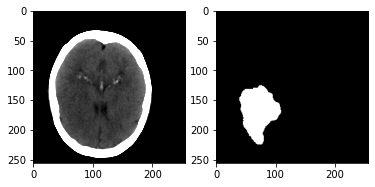

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(CT_Train[3,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,2,2)
plt.imshow(OT_Train[3,:,:,0],cmap='gray', vmin=0, vmax=1)

In [ ]:
# https://www.tensorflow.org/tutorials/images/segmentation
# tensor-flow unet

base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)
tf.keras.utils.plot_model(base_model, show_shapes=True)
base_model.trainable = True

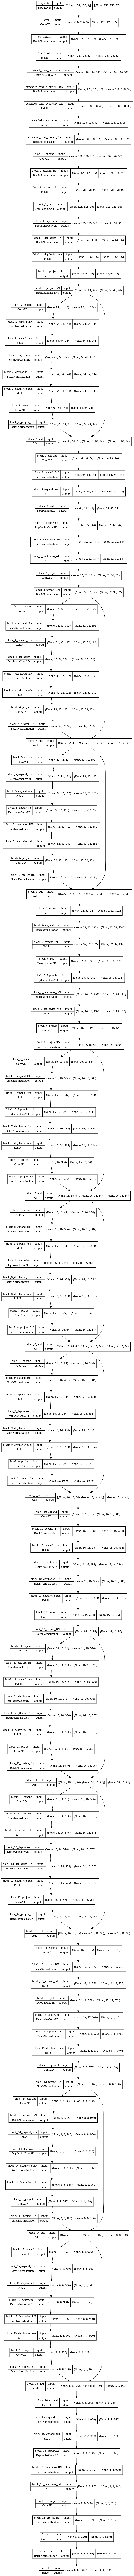

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128x128
    'block_3_expand_relu',   # 64x64
    'block_6_expand_relu',   # 32x32
    'block_13_expand_relu',  # 16x16
    'block_16_project',      # 8x8
    ]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = True

In [ ]:
up_stack = [
    pix2pix.upsample(256, 3),  # 4x4 -> 8x8
    pix2pix.upsample(128, 3),  # 8x8 -> 16x16
    pix2pix.upsample(64, 3),  # 16x16 -> 32x32
    pix2pix.upsample(32, 3),   # 32x32 -> 64x64
]

In [ ]:
def symarm_unet_model(output_channels:int):
  inputs0 = tf.keras.layers.Input(shape=[256, 256, 1])

  cov_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', data_format='channels_last',input_shape = [256, 256, 1])
  inputs = cov_layer(inputs0)

  
  # Downsampling through the model - image
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs0, outputs=x)

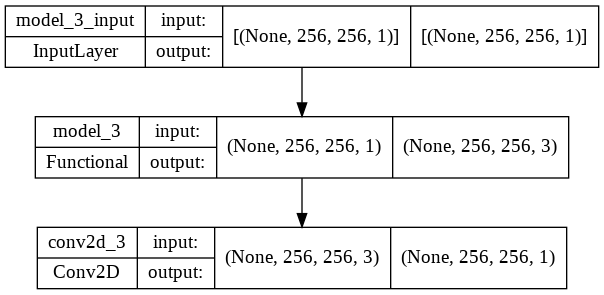

In [ ]:
OUTPUT_CLASSES = 3
train_shape = 256, 256, 1
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', data_format='channels_last',input_shape=train_shape))
model.add(symarm_unet_model(output_channels=OUTPUT_CLASSES))
model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same'))
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred).numpy()
  y_pred[y_pred > 0.5] = 1
  y_pred[y_pred < 0.5] = 0
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / denominator
  
def weighted_cross_entropy(beta):
  def loss(y_true, y_pred):
    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = 1 - tf.cast(y_true, tf.float32)
    
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
    return tf.reduce_mean(o)

  return loss

def my_loss(alpha, beta):
  def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    weight_a = beta * tf.cast(y_true, tf.float32)
    weight_b = 1 - tf.cast(y_true, tf.float32)
    o = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 

    return alpha * (1 - numerator / denominator) + tf.reduce_mean(o)
  return dice_loss

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.000001),
              loss=weighted_cross_entropy(beta = 5000),
              metrics=['binary_accuracy'])

0.001 - train 10 times \\
0.0001 - train 10 times \\
0.00001 - train 5 times \\
0.0000001 - train 5 times

In [ ]:
model_history = model.fit(x = CT_Train, y = OT_Train, batch_size=40, epochs = 5, verbose='auto')

Epoch 1/5
30/30 [==============================] - 18s 446ms/step - loss: 0.2067 - binary_accuracy: 0.9672
Epoch 2/5
30/30 [==============================] - 14s 451ms/step - loss: 0.2032 - binary_accuracy: 0.9673
Epoch 3/5
30/30 [==============================] - 14s 457ms/step - loss: 0.2056 - binary_accuracy: 0.9672
Epoch 4/5
30/30 [==============================] - 14s 461ms/step - loss: 0.2108 - binary_accuracy: 0.9675
Epoch 5/5
30/30 [==============================] - 13s 448ms/step - loss: 0.2031 - binary_accuracy: 0.9675


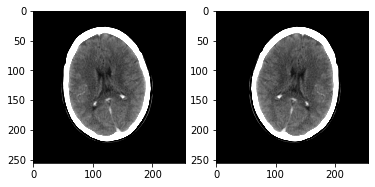

In [ ]:
ind = 26
aa = tf.image.flip_left_right(CT_Train)
plt.subplot(1,2,1)
plt.imshow(CT_Train[ind,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,2,2)
plt.imshow(aa[ind,:,:,0],cmap='gray', vmin=0, vmax=100)

In [ ]:
pred_OT=model.predict(CT_Train)

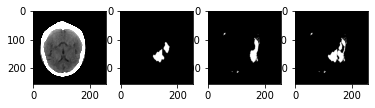

In [ ]:
ind = 42
plt.subplot(1,4,1)
plt.imshow(CT_Train[ind,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,4,2)
plt.imshow(OT_Train[ind,:,:,0],cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,3)
pred_map = tf.math.sigmoid(pred_OT[ind,:,:,0]).numpy()
pred_map[pred_map<0.5] = 0
pred_map[pred_map>0.5] = 1
plt.imshow(pred_map,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(np.abs(pred_map - OT_Train[ind,:,:,0]),cmap='gray', vmin=0, vmax=1)

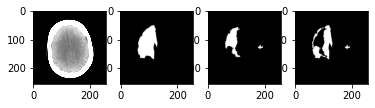

In [ ]:
ind = 36
plt.subplot(1,4,1)
plt.imshow(CT_Train[ind,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,4,2)
plt.imshow(OT_Train[ind,:,:,0],cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,3)
pred_map = tf.math.sigmoid(pred_OT[ind,:,:,0]).numpy()
pred_map[pred_map<0.5] = 0
pred_map[pred_map>0.5] = 1
plt.imshow(pred_map,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(np.abs(pred_map - OT_Train[ind,:,:,0]),cmap='gray', vmin=0, vmax=1)

In [ ]:
# save model
model_path = '/content/drive/Shared drives/CS230 project/symmetry encode Unet/Test with new data/baseline Unet'
model.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/Shared drives/CS230 project/symmetry encode Unet/Test with new data/baseline Unet/assets


In [ ]:
#load model
model_path = '/content/drive/Shared drives/CS230 project/symmetry encode Unet/Test with new data/baseline Unet'
model = tf.keras.models.load_model(model_path, compile=False)
model.trainable = False

# train

In [ ]:
# prediction
pred_OT=model.predict(CT_Train)
pred_OT_S = tf.math.sigmoid(pred_OT)

In [ ]:
# compute recall
m = tf.keras.metrics.Recall(thresholds = 0.5)
m.update_state(OT_Train, pred_OT_S)
m.result().numpy()

0.8093185

In [ ]:
# compute precision
m = tf.keras.metrics.Precision(thresholds = 0.5)
m.update_state(OT_Train, pred_OT_S)
m.result().numpy()

0.18916231

In [ ]:
# compute dice score
print(dice_loss(OT_Train, pred_OT))

tf.Tensor(0.30665094, shape=(), dtype=float32)


In [ ]:
from scipy.spatial.distance import directed_hausdorff

In [ ]:
# compute Hausdorff distance
pred_OT_1 = pred_OT_S.numpy()
pred_OT_1[pred_OT_1 < 0.5] = 0
pred_OT_1[pred_OT_1 > 0.5] = 1
mean_HD = 0
min_HD = 1000
HD_val_list = np.zeros((1,1200))
for i in range(1200):
  HD_val = max(directed_hausdorff(pred_OT_1[i,:,:,0], OT_Train[i,:,:,0])[0], directed_hausdorff(OT_Train[i,:,:,0], pred_OT_1[i,:,:,0])[0])
  mean_HD += HD_val
  min_HD = min(min_HD, HD_val)
  HD_val_list[0,i] = HD_val
mean_HD /= 1200
print(mean_HD)
print(min_HD)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


5.497451557912055
1.0


# dev

In [ ]:
# prediction
pred_OT_dev=model.predict(CT_dev)
pred_OT_S_dev = tf.math.sigmoid(pred_OT_dev)

In [ ]:
# compute recall
m = tf.keras.metrics.Recall(thresholds = 0.5)
m.update_state(OT_dev, pred_OT_S_dev)
m.result().numpy()

0.79693085

In [ ]:
# compute precision
m = tf.keras.metrics.Precision(thresholds = 0.5)
m.update_state(OT_dev, pred_OT_S_dev)
m.result().numpy()

0.24649183

In [ ]:
# compute dice score
print(dice_loss(OT_dev, pred_OT_dev))

tf.Tensor(0.3765242, shape=(), dtype=float32)


In [ ]:
# compute Hausdorff distance
pred_OT_1 = pred_OT_S_dev.numpy()
pred_OT_1[pred_OT_1 < 0.5] = 0
pred_OT_1[pred_OT_1 > 0.5] = 1
mean_HD = 0
min_HD = 1000
HD_val_list = np.zeros((1,50))
for i in range(50):
  HD_val = max(directed_hausdorff(pred_OT_1[i,:,:,0], OT_dev[i,:,:,0])[0], directed_hausdorff(OT_dev[i,:,:,0], pred_OT_1[i,:,:,0])[0])
  mean_HD += HD_val
  min_HD = min(min_HD, HD_val)
  HD_val_list[0,i] = HD_val
mean_HD /= 50
print(mean_HD)

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:456: UserWarning: you are shuffling a '_memoryviewslice' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  result = _hausdorff.directed_hausdorff(u, v, seed)


5.247856833769209


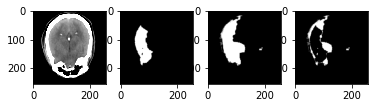

In [ ]:
ind = 12
plt.subplot(1,4,1)
plt.imshow(CT_dev[ind,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,4,2)
plt.imshow(OT_dev[ind,:,:,0],cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,3)
pred_map = tf.math.sigmoid(pred_OT_dev[ind,:,:,0]).numpy()
pred_map[pred_map<0.5] = 0
pred_map[pred_map>0.5] = 1
plt.imshow(pred_map,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(np.abs(pred_map - OT_dev[ind,:,:,0]),cmap='gray', vmin=0, vmax=1)


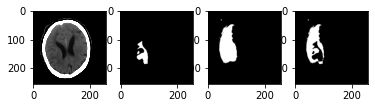

In [ ]:
ind = 35
plt.subplot(1,4,1)
plt.imshow(CT_dev[ind,:,:,0],cmap='gray', vmin=0, vmax=100)
plt.subplot(1,4,2)
plt.imshow(OT_dev[ind,:,:,0],cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,3)
pred_map = tf.math.sigmoid(pred_OT_dev[ind,:,:,0]).numpy()
pred_map[pred_map<0.5] = 0
pred_map[pred_map>0.5] = 1
plt.imshow(pred_map,cmap='gray', vmin=0, vmax=1)
plt.subplot(1,4,4)
plt.imshow(np.abs(pred_map - OT_dev[ind,:,:,0]),cmap='gray', vmin=0, vmax=1)